# SP500 Backtesting Improvement

## Introduction
This notebook makes some updates on the stuff have done of previous backtesting on SP500. The previous version just mimic what I have done in DJIA cases but the performance is quite bad. In this notebook, I tried 2 main methods to improve the performance:
1. Adjust the threshold of predicting to be up or down.
2. Add stop loss to the strategy based on the drawdown of previous day if we have position.
3. Add one more class 0, which represents that we are not sure about the market movement.

## Key Assumptions
1. Short selling is allowed.
2. All transaction cost, slippages are assumed to be 0, implied the market is frictionless.
3. Treat SP500 as something like a stock and the price is just the index level.
4. The initial investment is 100000

## Performance Calculation
1. Assume trading days for a year is 252.
2. Use 13 week US Treasury bill rate as risk free rate (converted to daily rate).
3. Sharpe ratio is calculated on a yearly basis.
4. Maximum drawdown is calculated based on the whole period, not in the rolling window format. 

## Part 1: Pre-modeling Set up

### 1.1 Import required libraries

In [1]:
# Import required libraries
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import quandl
from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import linear_model

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
# List to keep different methods scores to compare
ScoreSummaryByMethod=[]
FillAtClosePrice=[]
FillAtOpenPrice=[]

### 1.2 Import SP500 data and risk free rate

In [3]:
# Import SP500 data and risk free rate
SP500=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/SP500_table.xlsx')
SP500['Date']=pd.to_datetime(SP500['Date'])

### 1.3 Define several functions for further use
* text_process: text pre-processing
* ROCCurves: generate ROC curves
* heatmap: plot function
* plot_classification_report
* plot_confusion_matrix
* Evaluation: main function for evaluting the model, return AUC and other ket information
* **create_port**: create a portfolio for backtesting
* **backtest_close**: backtesting assume filling at T+0 adj close price
* **backtest_open**: backtesting assume filling at T+1 open price
* **performance**: generate performance report which indicates annualized return, annualized volatility, annualized Sharpe ratio, maximum drawdown

In [4]:
# Text pre-processing

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed

In [5]:
# ROC curve generation

def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [6]:
def heatmap(data, rotate_xticks=True):
  fig, ax = plt.subplots()
  heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
  ax.xaxis.tick_top()
  if rotate_xticks:
      plt.xticks(rotation=90)
  plt.yticks(rotation=0)

In [7]:
def plot_classification_report(classification_report):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

In [8]:
def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [9]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [10]:
# create a portfolio
def create_port(result):
    port=pd.merge(result,SP500,how='left',on='Date')[['Date','Open','Adj Close','Label','predict']]
    port['shares hold']=0
    port['PnL']=0
    port['wealth']=0
    port['drawdown']=0
    port['wealth'][0]=100000
    return port

In [11]:
# Backtest, assume fill at t+0 adjusted close price
# default slippage=0, transaction cost=0
# default no stop loss
def backtest_close(port,stop_loss=1):
    hwm=[0.0]
    #handle the starting day
    if port.loc[0,'predict']==1:
        port.loc[0,'shares hold']=port.loc[0,'wealth']/port.loc[0,'Adj Close']
    if port.loc[0,'predict']==-1:
        port.loc[0,'shares hold']=-port.loc[0,'wealth']/port.loc[0,'Adj Close']
    if port.loc[0,'predict']==0:
        port.loc[0,'shares hold']=0
        
    #handle the following days
    for i in range(1,port.index[-1]+1):
        if port.loc[i-1,'shares hold']==0:
            if port.loc[i,'predict']==1: # this is a buy signal
                port.loc[i,'shares hold']=port.loc[i-1,'wealth']/port.loc[i,'Adj Close']
                port.loc[i,'wealth']=port.loc[i,'shares hold']*port.loc[i,'Adj Close']
            if port.loc[i,'predict']==-1: # this is a short signal
                port.loc[i,'shares hold']=-port.loc[i-1,'wealth']/port.loc[i,'Adj Close']
                port.loc[i,'wealth']=-port.loc[i,'shares hold']*port.loc[i,'Adj Close']
            if port.loc[i,'predict']==0:
                port.loc[i,'wealth']=port.loc[i-1,'wealth']
        if port.loc[i-1,'shares hold']>0: # hold some shares
            if port.loc[i,'predict']==1 or port.loc[i,'predict']==0: # hold since we have shares in hand
                if port.loc[i-1,'drawdown']<=stop_loss:
                    port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                    port.loc[i,'PnL']=port.loc[i,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                    port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
                else:
                    port.loc[i,'shares hold']=0
                    port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                    port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
            if port.loc[i,'predict']==-1: # this is a sell signal (close position)
                #close the position
                port.loc[i,'shares hold']=0
                port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
        if port.loc[i-1,'shares hold']<0:
            if port.loc[i,'predict']==1: # close position
                port.loc[i,'shares hold']=0
                port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
            if port.loc[i,'predict']==-1 or port.loc[i,'predict']==0:
                if port.loc[i-1,'drawdown']<=stop_loss:
                    port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                    port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                    port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
                else:
                    port.loc[i,'shares hold']=0
                    port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                    port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
        current_hwm=max(hwm[i-1],port['wealth'][i])
        hwm.append(current_hwm)
        port.loc[i,'drawdown']=float((hwm[i]-port['wealth'][i]))/float(hwm[i])
    port['return']=port['wealth'].pct_change()
    return port[['Date','shares hold','PnL','wealth','return','drawdown']]

In [12]:
# Backtest, assume fill at t+1 open price
# default slippage=0, transaction cost=0, interest=0
def backtest_open(port,stop_loss=1):
    hwm=[0.0]
    for i in range(0,port.index[-1]):
        if port.loc[i,'shares hold']==0: #position at i is 0
            if port.loc[i,'predict']==1: #prediction at i is 1, this is a buy signal
                #wealth at i will not change, but the shares hold at i+1 will change, shares hold(i+1)=wealth(i)/Open(i+1)
                port.loc[i+1,'shares hold']=port.loc[i,'wealth']/port.loc[i+1,'Open']
                #wealth(i+1) will be shares hold(i+1)*Open(i+2)
                port.loc[i+1,'wealth']=port.loc[i+1,'shares hold']*port.loc[i+1,'Open']
            if port.loc[i,'predict']==-1: #prediction at i is 0, this is a short signal
                port.loc[i+1,'shares hold']=-port.loc[i,'wealth']/port.loc[i+1,'Open']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']
            if port.loc[i,'predict']==0:
                port.loc[i+1,'wealth']=port.loc[i,'wealth']
        if port.loc[i,'shares hold']>0: #position at i is not 0
            if port.loc[i,'predict']==1 or port.loc[i,'predict']==0: #prediction at i is 1, just hold the shares for i+1
                if port.loc[i,'drawdown']<=stop_loss:
                    # shares at i+1 is the same as shares at i
                    port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                    port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                    port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
                else:
                    port.loc[i+1,'shares hold']=0
                    port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                    port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
            if port.loc[i,'predict']==-1: #prediction at i is 0, this is a sell signal (close position)
                # shares at i+1 should be 0
                port.loc[i+1,'shares hold']=0
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
        if port.loc[i,'shares hold']<0: #position at i is not 0
            if port.loc[i,'predict']==1:
                port.loc[i+1,'shares hold']=0
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
            if port.loc[i,'predict']==-1 or port.loc[i,'predict']==0:
                if port.loc[i,'drawdown']<=stop_loss:
                    port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                    port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                    port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
                else:
                    port.loc[i+1,'shares hold']=0
                    port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                    port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
        current_hwm=max(hwm[i],port['wealth'][i+1])
        hwm.append(current_hwm)
        port.loc[i+1,'drawdown']=float((hwm[i+1]-port['wealth'][i+1]))/float(hwm[i+1])
    port['return']=port['wealth'].pct_change()
    return port[['Date','shares hold','PnL','wealth','return']]

In [13]:
#report annualized return, volatility and Sharpe ratio
def performance(Method, Comment, Improvement, fill_type, port,N=252):
    #default number of a year is N=252
    print("Classification method: ",Method)
    print("Paremeters choose: ", Comment)
    print("Order fill type: ", fill_type)
    #annualized mean of return
    annual_return=N*port['return'].mean()
    #annulized standard deviation
    annual_sd=np.sqrt(N)*port['return'].std()
    #annualized sharpe ratio
    #use 13-week US Treasury bill rate as risk free rate (benchmark)
    daily_sharpe=port['return'].mean() / port['return'].std()
    annual_sharpe=np.sqrt(N) * daily_sharpe
    
    hwm=[0.0]
    idx=port.index
    drawdown=pd.DataFrame(port['Date'])
    drawdown['dd']=0.0
    for i in range(1,len(idx)):
        current_hwm=max(hwm[i-1],port['wealth'][i])
        hwm.append(current_hwm)
        drawdown['dd'][i]=float((hwm[i]-port['wealth'][i]))/float(hwm[i])
    max_drawdown=drawdown['dd'].max()
    print("The annualized return is "+"{:.4%}".format(annual_return))
    print("The annualized volatility is "+"{:.4%}".format(annual_sd))
    print("The annualized Sharpe ratio is "+"{:.4}".format(annual_sharpe))
    print("The maximum drawdown during backtesting period is "+"{:.4%}".format(max_drawdown))
    
    #Create the performance plots
    '''
    fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(6,4))
    axes[0].plot(port['Date'],port['wealth'])
    axes[0].set_title('Wealth curve')
    axes[1].plot(port['Date'],port['return'])
    axes[1].set_title('Return')
    axes[2].plot(drawdown['Date'], drawdown['dd'])
    axes[2].set_title('Drawdown')
    plt.tight_layout()
    fig.autofmt_xdate()
    '''
    
    port.plot('Date','wealth')
    port.plot('Date','return')
    drawdown.plot('Date','dd')
    if fill_type=='close':
        FillAtClosePrice.append([Method, Comment, Improvement, annual_return, annual_sd, annual_sharpe,max_drawdown])
    if fill_type=='open':
        FillAtOpenPrice.append([Method, Comment, Improvement, annual_return, annual_sd, annual_sharpe,max_drawdown])

## Part 2: Modeling and backtesting
The main task in this section is to model and backtest the strategy. The basic flow is:
1. Import modeling dataset
2. Combine predictions with SP500 dataset and backtesting the strategy by assuming filling at T+0 adjusted close price and T+1 open price respectively
3. Report the annulized return, annualized volatility, annualized Sharpe ratio and maximum drawdown

I will examine the following methods:
1. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news
2. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 3-day shift, combined all top news
3. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 2-day shift, combined top3,top12 and top25 news

The comparison results are stores in the following tables:
1. df_ScoreSummaryByMethod: modeling scores for different methods
2. df_FillAtClosePrice: performance for different methods assuming filling at T+0 adjusted close price
3. df_FillAtOpenPrice: performance for different methods assuming filling at T+1 open price
The latter 2 tables are sorted by Sharpe ratio in descending order.


### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news

Now, we will use the news in day i to make prediction for day i+1. In this case, I will backtest the following strategy:
1. Assume fill at T+0 adjusted close price:
    * If we do not have position in previous day (day i-1) and if the prediction is 1, we invest all of our money in the SP500, else (the prediction is 0), we short the amount of shares that we can long at that day's adjusted close price. 
    * If we have positive position (long) in previous day (day i-1) and if the prediction is 0, we clear our position at that day's adjusted close price, else (the prediction is 1), we just hold the shares. 
    * If we have negative position (short) in previous day (day i-1) and if the prediction is 0, we hold the short position and if the prediction, we close the position by buying at the adjusted close price of that day.
2. Assume fill at T+1 open price:
    * If we do not have position in day i and if the prediction is 1, we invest all of our money in the SP500 at the open price of day i+1, else (the prediction is 0), short the amount of shares that we can long at the open price of day i+1. 
    * If we have positive (long) position in SP500 at day i and if the prediction is 0, we close our position at day i+1's open price, else (the prediction is 1), we just hold the shares. 
    * If we have short position in SP500 at day i and if the prediction is 1, we close our position at day i+1's open price, else (the prediction is 0), we just hold the short position. 

In [14]:
#1 days shift
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]

In [15]:
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier',BernoulliNB(alpha=0.1,binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict_model']=predictions
test['up_prob']=bnb_2ngram_pipeline.predict_proba(test['Combined'])[:,1]
test['down_prob']=bnb_2ngram_pipeline.predict_proba(test['Combined'])[:,0]
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.1,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.54      0.34      0.42       190
        1.0       0.51      0.70      0.59       187

avg / total       0.52      0.52      0.50       377

Confussion matrix:
 [[ 65 125]
 [ 56 131]]
ROC-AUC: 0.521320011258


#### Improvement 1: Adjust the threshold of predicting to be a up movement
The best result is when the up probability is greater than 0.99, then regard it as up. In this case, if assume filling at t+0 close price, the Sharpe ratio is 1.628. If assume filling at t+1 open price, the Sharpe ratio is 1.822.

In [16]:
test['predict']=test['up_prob'].apply(lambda x: 1 if x>=0.99 else -1 if x<0.99 else 0)

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is 19.7488%
The annualized volatility is 12.1273%
The annualized Sharpe ratio is 1.628
The maximum drawdown during backtesting period is 7.4795%


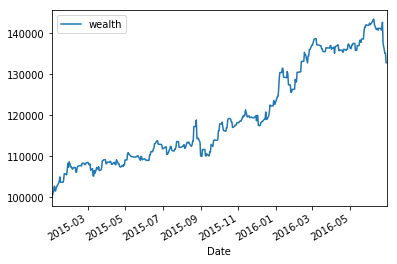

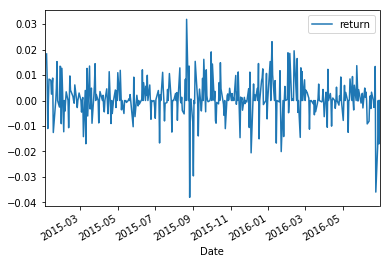

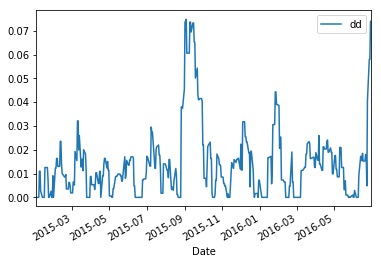

In [17]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 1','close',result_close)  

In the case that filling at t+1 open price, the Sharpe ratio has been increased to 1.822

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is 20.6002%
The annualized volatility is 11.3039%
The annualized Sharpe ratio is 1.822
The maximum drawdown during backtesting period is 7.3200%


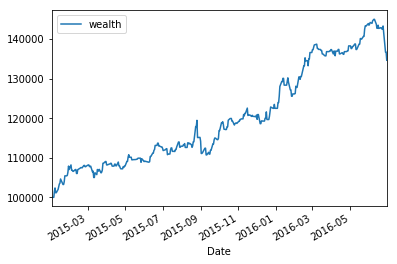

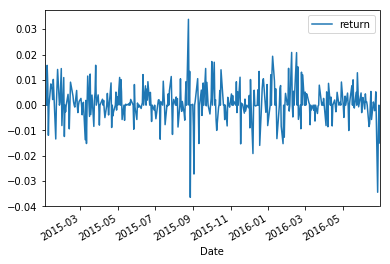

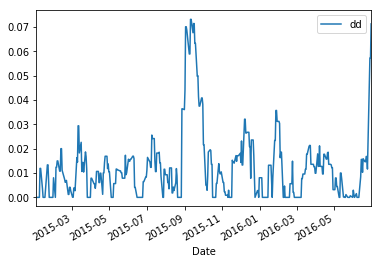

In [18]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 1','open',result_open)  

#### Improvement 2: Add one more class
Now consider to create one more class 0, which represnts that we are not sure about the market movement. When the prediction is 0, then we just hold our cash if we do not have position, meaning that we are neutral about the market.

In [19]:
# Best result for up and down is: up=0.99, down=0.05
test['predict']=test['up_prob'].apply(lambda x, up=0.99, down=0.05: 1 if x>=up else -1 if x<down else 0)

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is 18.5169%
The annualized volatility is 13.0858%
The annualized Sharpe ratio is 1.415
The maximum drawdown during backtesting period is 7.1035%


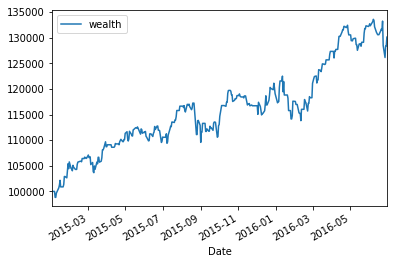

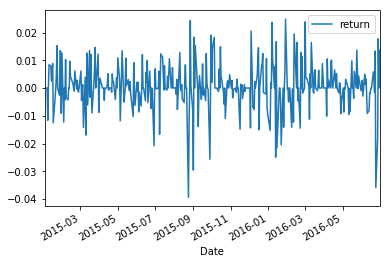

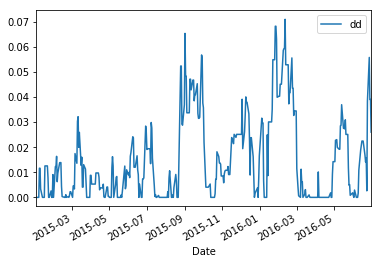

In [20]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 2','close',result_close)  

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is 17.4845%
The annualized volatility is 12.0014%
The annualized Sharpe ratio is 1.457
The maximum drawdown during backtesting period is 6.2069%


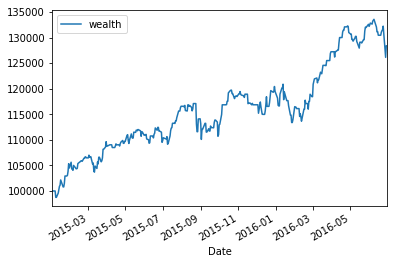

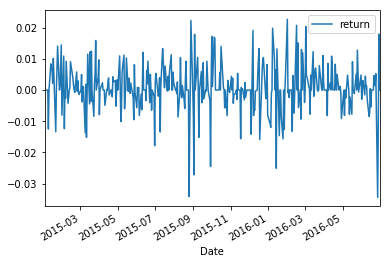

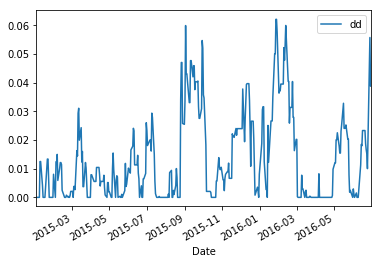

In [21]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 2','open',result_open)

#### Improvement 3: Set stop loss
I will compute the drawdown for each day and when we have a position and if the signal is to hold that position, we will check the drawdown for previous day to see whether it is over the pre-set value. If yes, liquidite the position and if not, hold the position.

The best value for the stop-loss can be obtained and here I tried several and get it to be 0.1%

In [22]:
test['predict']=test['predict_model']

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is 10.9129%
The annualized volatility is 10.6637%
The annualized Sharpe ratio is 1.023
The maximum drawdown during backtesting period is 7.2233%


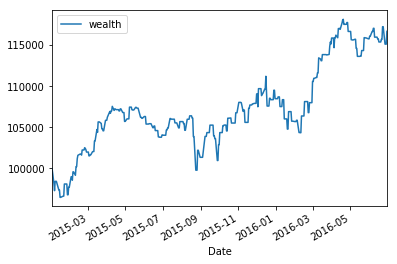

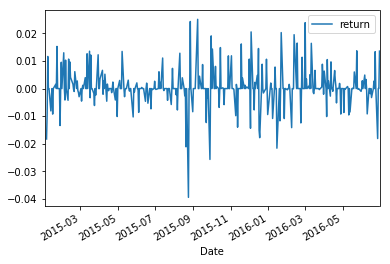

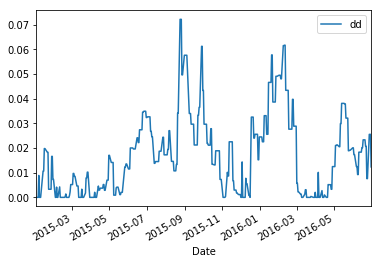

In [23]:
portfolio=create_port(test)
result_close=backtest_close(portfolio,0.001)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 3','close',result_close)  

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is 8.7176%
The annualized volatility is 9.5995%
The annualized Sharpe ratio is 0.9081
The maximum drawdown during backtesting period is 7.1823%


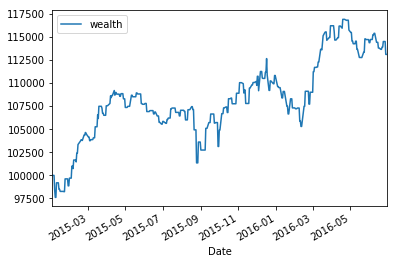

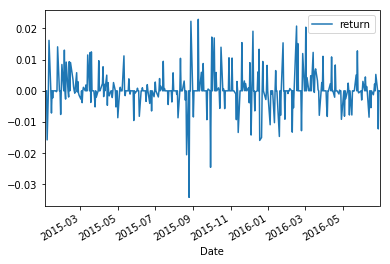

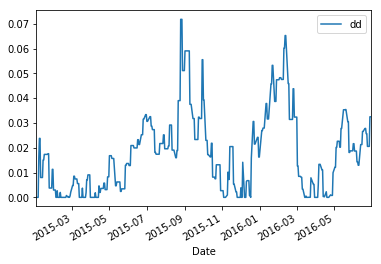

In [24]:
portfolio=create_port(test)
result_open=backtest_open(portfolio,0.001)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','Improvement 3','open',result_open)  

### Neural network
After some paramter's optimization, the AUC for neural network can be improved a little bit. 

In [25]:
#try neural network
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25']]
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100, 3), alpha=1e-4, random_state=1))])
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
test['predict_model']=predictions
test['up_prob']=bnb_2ngram_pipeline.predict_proba(test['Combined3_12_25'])[:,1]
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

MLPClassifier(alpha=1e-4,hidden_layer_size=100)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.55      0.41      0.47       189
        1.0       0.53      0.66      0.59       187

avg / total       0.54      0.54      0.53       376

Confussion matrix:
 [[ 78 111]
 [ 63 124]]
ROC-AUC: 0.537900008488


## Summary Table Combining Improving Methods

In [26]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_FillAtClosePrice=DataFrame(FillAtClosePrice,columns=['Method','Comment','Improvement','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtClosePrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)
df_FillAtOpenPrice=DataFrame(FillAtOpenPrice,columns=['Method','Comment','Improvement','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtOpenPrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)

In [27]:
df_ScoreSummaryByMethod

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
1,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.53790,0.527660,0.537234,0.663102,0.587678
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.52132,0.511719,0.519894,0.700535,0.591422


In [28]:
df_FillAtClosePrice

,Method,Comment,Improvement,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 1,0.197488,0.121273,1.628457,0.074795
1,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 2,0.185169,0.130858,1.415034,0.071035
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 3,0.109129,0.106637,1.023372,0.072233


In [29]:
df_FillAtOpenPrice

,Method,Comment,Improvement,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 1,0.206002,0.113039,1.822402,0.073200
1,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 2,0.174845,0.120014,1.456876,0.062069
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",Improvement 3,0.087176,0.095995,0.908136,0.071823


In [31]:
df_FillAtClosePrice.to_excel("/Users/chester/Desktop/Peter_project/output/SP500_improve/fill_at_close.xlsx",index=False)
df_FillAtOpenPrice.to_excel("/Users/chester/Desktop/Peter_project/output/SP500_improve/fill_at_open.xlsx",index=False)